In [87]:
import rawpy, imageio

In [88]:
raw = rawpy.imread('./pic/raw_capture_g8.jpg')

In [89]:
print(raw.sizes)

ImageSizes(raw_height=2464, raw_width=3280, height=2464, width=3280, top_margin=0, left_margin=0, iheight=2464, iwidth=3280, pixel_aspect=1.0, flip=0)


In [90]:
import numpy as np

In [91]:
raw_array = raw.raw_image

In [92]:
h, w = raw_array.shape
print(h, w)

2464 3280


In [93]:
import matplotlib.pyplot as plt

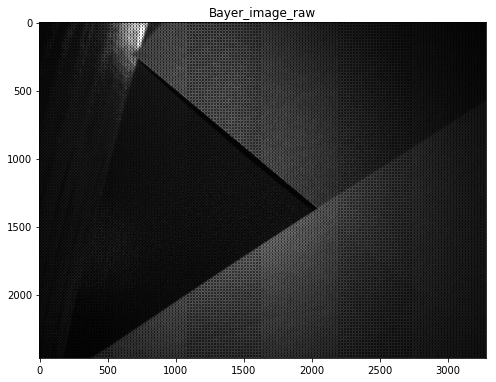

In [94]:
plt.figure(figsize=(8, 8))

plt.imshow(raw_array, cmap='gray')

plt.title(u"Bayer_image_raw")

plt.show()

In [95]:
plt.figure(figsize=(8, 8))

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

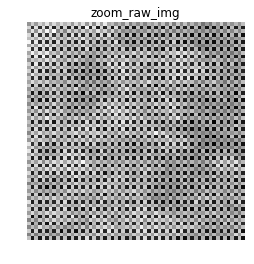

In [96]:
plt.imshow(raw_array[1340:1400, 2640:2700], cmap='gray')
plt.axis('off')
plt.title(u"zoom_raw_img")
plt.show()

In [97]:
print(raw.raw_pattern)


[[2 3]
 [1 0]]


In [98]:
# raw_arrayと同じ大きさで、３色のデータを持つnumpyの行列を作る。
# zerosは指定された大きさの０行列を作るコマンド。
raw_color = np.zeros((h, w, 3))

# 偶数列、偶数行の画素は青なので、青チャンネル（2）にコピー。
raw_color[0::2, 0::2, 2] = raw_array[0::2, 0::2]
# 奇数列、偶数行の画素は緑なので、緑チャンネル（1）にコピー。
raw_color[0::2, 1::2, 1] = raw_array[0::2, 1::2]
# 偶数列、奇数行の画素は緑なので、緑チャンネル（1）にコピー。
raw_color[1::2, 0::2, 1] = raw_array[1::2, 0::2]
# 奇数列、奇数行の画素は赤なので、赤チャンネル(0）にコピー。
raw_color[1::2, 1::2, 0] = raw_array[1::2, 1::2]

# 0から1の範囲にノーマライズ
raw_color[raw_color < 0] = 0
raw_color = raw_color / 1024

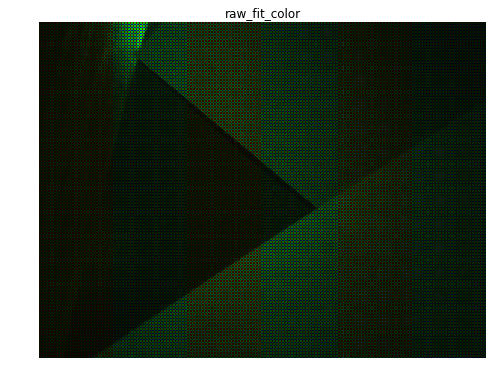

In [99]:
plt.figure(figsize=(8, 8))
plt.imshow(raw_color)
plt.axis('off')
plt.title(u'raw_fit_color')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


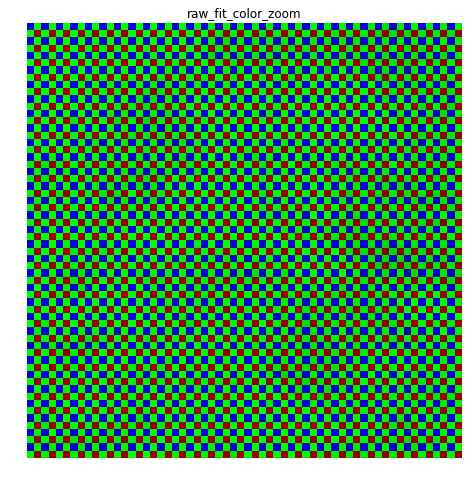

In [100]:
plt.figure(figsize=(8, 8))

digital_gain = 4
plt.imshow(raw_color[1340:1400, 2640:2700] * digital_gain)
plt.axis('off')
plt.title(u'raw_fit_color_zoom')
plt.show()

In [101]:
pattern = raw.raw_pattern
pattern[pattern==3] = 1
print(pattern)

[[2 1]
 [1 0]]


In [102]:
dms_img = np.zeros((h//2, w//2, 3))

for y in range(0, h, 2):
        for x in range(0, w, 2):
                dms_img[y//2, x//2, pattern[0, 0]] += \
                    raw_array[y + 0, x + 0]
                dms_img[y//2, x//2, pattern[0, 1]] += \
                    raw_array[y + 0, x + 1]
                dms_img[y//2, x//2, pattern[1, 0]] += \
                    raw_array[y + 1, x + 0]
                dms_img[y//2, x//2, pattern[1, 1]] += \
                    raw_array[y + 1, x +1]
                dms_img[y//2, x//2, 1] /= 2

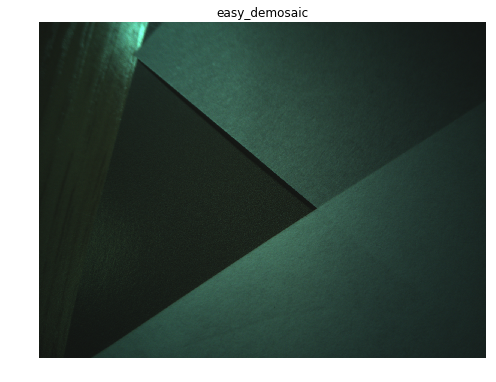

In [103]:
dms_img[dms_img < 0] = 0

dms_img /= 1024

plt.figure(figsize=(8, 8))
plt.imshow(dms_img)
plt.axis('off')
plt.title(u'easy_demosaic')
plt.show()

In [104]:
def simple_demosaic(raw_array, pattern):
    """
    簡易デモザイク処理を行う。

    Parameters
    ----------
    raw_array: numpy array
        入力BayerRAW画像データ
    pattern: int[2, 2]
        ベイヤーパターン。0:赤、1:緑、2:青、3:緑。

    Returns

    -------
    dms_img: numpy array
        出力RGB画像。サイズは入力の縦横共に1/2。
    """
    height, width = raw_array.shape
    dms_img = np.zeros((height//2, width//2, 3))
    pattern[pattern == 3] = 1
    dms_img[:, :, pattern[0, 0]] = raw_array[0::2, 0::2]
    dms_img[:, :, pattern[0, 1]] += raw_array[0::2, 1::2]
    dms_img[:, :, pattern[1, 0]] += raw_array[1::2, 0::2]
    dms_img[:, :, pattern[1, 1]] += raw_array[1::2, 1::2]
    dms_img[:, :, 1] /= 2
    return dms_img

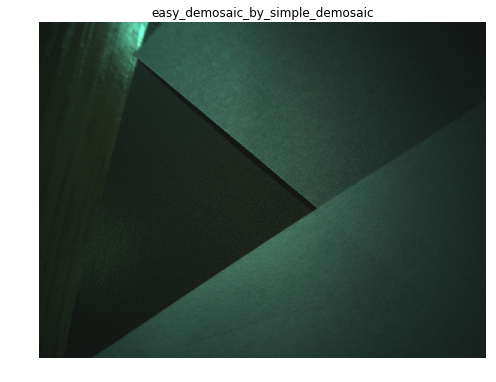

In [105]:
dms_img = simple_demosaic(raw_array, raw.raw_pattern)

dms_img[dms_img < 0] = 0
dms_img /= 1024

plt.figure(figsize=(8, 8))
plt.imshow(dms_img)
plt.axis('off')
plt.title(u'easy_demosaic_by_simple_demosaic')
plt.show()

In [106]:
wb = raw.camera_whitebalance
print(wb)

[1.875, 1.0, 1.3040000200271606, 1.0]


In [107]:
wb_img = raw_array.copy()

pattern = raw.raw_pattern
for y in range(0, h):
        for x in range(0, w):
                c = pattern[y % 2, x % 2]
                wb_img[y, x] *= wb[c]

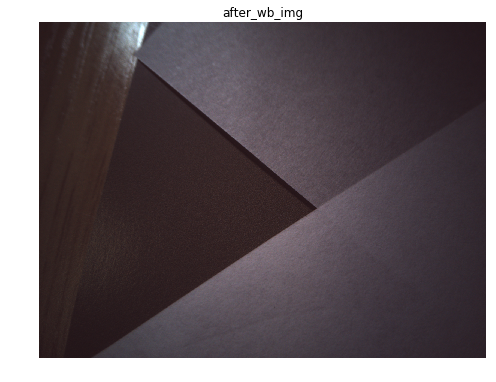

In [108]:
dms_img = simple_demosaic(wb_img, raw.raw_pattern)

dms_img /= 1024
dms_img[dms_img < 0] = 0
dms_img[dms_img > 1] = 1.0

plt.figure(figsize=(8, 8))
plt.imshow(dms_img)
plt.axis('off')
plt.title(u"after_wb_img")
plt.show()

In [109]:
def white_balance(raw_array, wb_gain, raw_colors):
    """
    ホワイトバランス補正処理を行う。

    Parameters
    ----------
    raw_array: numpy array
        入力BayerRAW画像データ。
    wb_gain: float[4]
        ホワイトバランスゲイン。
    raw_colors: int[h, w]
        RAW画像のカラーチャンネルマトリクス。

    Returns
    -------
    wb_img: numpy array
        出力RAW画像。
    """
    norm = wb_gain[1]
    gain_matrix = np.zeros(raw_array.shape)
    for color in (0, 1, 2, 3):
        gain_matrix[raw_colors == color] = wb_gain[color] / norm
    wb_img = raw_array * gain_matrix
    return wb_img

In [110]:
gain, colors = raw.camera_whitebalance, raw.raw_colors
wb_img = white_balance(raw_array, gain, colors)

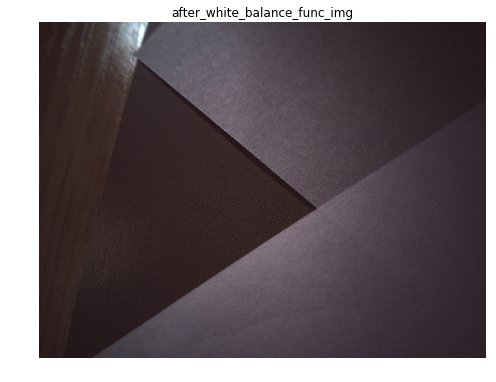

In [111]:
dms_img = simple_demosaic(wb_img, raw.raw_pattern)

dms_img /= 1024
dms_img[dms_img < 0] = 0
dms_img[dms_img > 1] = 1.0

plt.figure(figsize=(8, 8))
plt.imshow(dms_img)
plt.axis('off')
plt.title(u"after_white_balance_func_img")
plt.show()

In [112]:
blc = raw.black_level_per_channel
print(blc)

[66, 66, 66, 66]


In [113]:
# ベイヤー配列パターンを変数に保存
pattern = raw.raw_pattern

# RAWデータを符号付き整数としてコピー。
blc_raw = raw_array.astype('int')
# 各画素毎に対応するブラックレベルを参照して引いていく。
for y in range(0, h, 2):
    for x in range(0, w, 2):
        blc_raw[y + 0, x + 0] -= blc[pattern[0, 0]]
        blc_raw[y + 0, x + 1] -= blc[pattern[0, 1]]
        blc_raw[y + 1, x + 0] -= blc[pattern[1, 0]]
        blc_raw[y + 1, x + 1] -= blc[pattern[1, 1]]

In [114]:
print("ブラックレベル補正前: 最小値=", raw_array.min(), 
      ", 最大値=", raw_array.max())
print("ブラックレベル補正後: 最小値=", blc_raw.min(), 
      ", 最大値=", blc_raw.max())

ブラックレベル補正前: 最小値= 69 , 最大値= 1023
ブラックレベル補正後: 最小値= 3 , 最大値= 957


In [115]:
# 最初に定義したwhite_balance()関数を使って、ホワイトバランス調整。
gain, colors = raw.camera_whitebalance, raw.raw_colors
wb_img = white_balance(blc_raw, gain, colors)
# simple_demosaic()関数を使って、簡易デモザイク処理。
dms_img = simple_demosaic(wb_img, raw.raw_pattern)

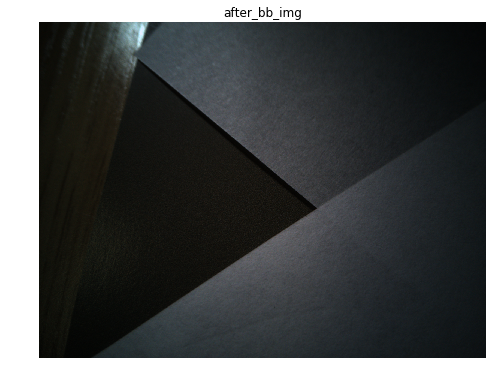

In [116]:
# 表示
plt.figure(figsize=(8, 8))
# imshowでは画像は0から1.0の値をとる必用があるので、ノーマライズする。
dms_img /= 1024
dms_img[dms_img<0] = 0
dms_img[dms_img>1] = 1
# 画像表示
plt.imshow(dms_img)
plt.axis('off')
plt.title(u"after_bb_img")
plt.show()

In [117]:
def black_level_correction(raw_array, blc, pattern):
    """ 
    ブラックレベル補正処理を行う。
    
    Parameters
    ----------
    raw_array: numpy array
        入力BayerRAW画像データ。
    blc: float[4]
        各カラーチャンネルごとのブラックレベル。
    pattern: int[2, 2]
        ベイヤーパターン。0:赤、1:緑、2:青、3:緑。
        
    Returns
    -------
    blc_raw: numpy array
        出力RAW画像。
    """    
    # 符号付き整数として入力画像をコピー
    blc_raw = raw_array.astype('int')
    # 各カラーチャンネル毎にブラックレベルを引く。
    blc_raw[0::2, 0::2] -= blc[pattern[0, 0]]
    blc_raw[0::2, 1::2] -= blc[pattern[0, 1]]
    blc_raw[1::2, 0::2] -= blc[pattern[1, 0]]
    blc_raw[1::2, 1::2] -= blc[pattern[1, 1]]
    return blc_raw

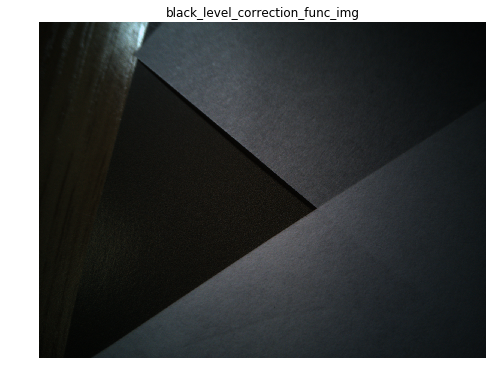

In [118]:
# 上記のblack_level_correction関数を使用してブラックレベル補正。
blc_raw = black_level_correction(raw_array, blc, raw.raw_pattern)
# 最初に定義したwhite_balance()関数を使って、ホワイトバランス調整。
gain, colors = raw.camera_whitebalance, raw.raw_colors
wb_img = white_balance(blc_raw, gain, colors)
# simple_demosaic()関数を使って、簡易デモザイク処理。
dms_img = simple_demosaic(wb_img, raw.raw_pattern)

# 表示
plt.figure(figsize=(8, 8))
# imshowでは画像は0から1.0の値をとる必用があるので、ノーマライズする。
dms_img /= 1024
dms_img[dms_img<0] = 0
dms_img[dms_img>1] = 1
# 画像表示
plt.imshow(dms_img)
plt.axis('off')
plt.title(u"black_level_correction_func_img")
plt.show()

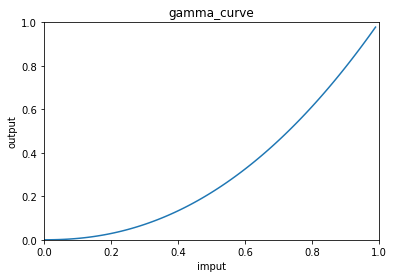

In [119]:
# 0~1.0の範囲の値を0.01刻みで作る。
xs = np.arange(0.0, 1.0, 0.01)
# xsに対応したx^2.2の値を作る。
ys = np.power(xs, 2.2)
# Pyplotの機能でグラフ表示。
plt.plot(xs, ys)
# ｘ軸とｙ軸の範囲を0-1.0に設定。
plt.xlim(0, 1.0)
plt.ylim(0, 1.0)
plt.title(u"gamma_curve")
plt.xlabel("imput")
plt.ylabel("output")
plt.show()

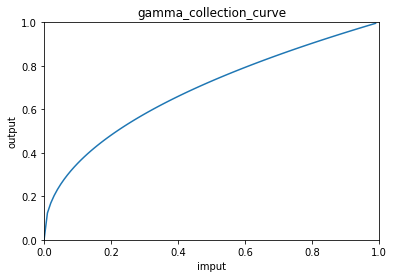

In [120]:
xs = np.arange(0.0, 1.0, 0.01)
ys = np.power(xs, 1/2.2)
plt.plot(xs, ys)
plt.xlim(0, 1.0)
plt.ylim(0, 1.0)
plt.title(u"gamma_collection_curve")
plt.xlabel("imput")
plt.ylabel("output")
plt.show()

In [121]:
# raw_processからインポートしたblack_level_correction関数を使用してブラックレベル補正。
blc, pattern = raw.black_level_per_channel, raw.raw_pattern
blc_raw = black_level_correction(raw_array, blc, pattern)
# raw_processからインポートしたwhite_balance()関数を使って、ホワイトバランス調整。
gain, colors = raw.camera_whitebalance, raw.raw_colors
wb_img = white_balance(blc_raw, gain, colors)
# raw_processからインポートしたsimple_demosaic()関数を使って、簡易デモザイク処理。
dms_img = simple_demosaic(wb_img, raw.raw_pattern)

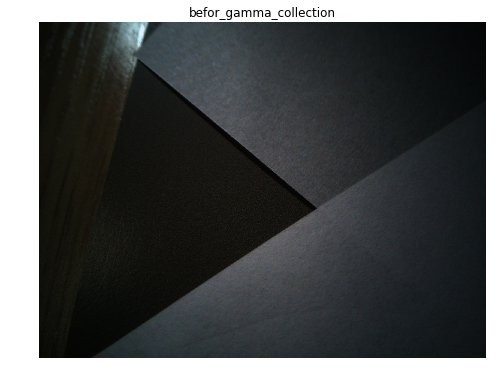

In [122]:
# 表示
plt.figure(figsize=(8, 8))
# imshowでは画像は0から1.0の値をとる必用があるのでノーマライズする。
img = dms_img.copy()
img /= 1024
img[img<0] = 0
img[img>1] = 1
plt.imshow(img)
plt.axis('off')
plt.title(u"befor_gamma_collection")
plt.show()

In [123]:
# デモザイク後の画像をfloatタイプとしてコピー。
gamma_img = dms_img.astype(float)
# ガンマ関数は0-1の範囲で定義されているので、その範囲に正規化する。
gamma_img[gamma_img < 0] = 0
gamma_img /= gamma_img.max()
# numpyのpower関数を使って、ガンマ関数を適用。
gamma_img = np.power(gamma_img, 1/2.2)

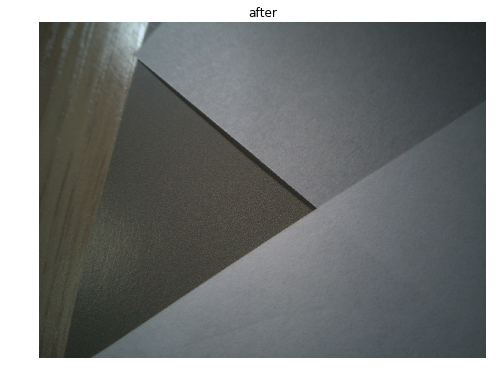

In [124]:
# 表示
plt.figure(figsize=(8, 8))
plt.imshow(gamma_img)
plt.axis('off')
plt.title(u"after")
plt.show()

In [125]:
def gamma_correction(gamma_img, gamma):
    """
    ガンマ補正処理を行う。

    Parameters
    ----------
    input_img: numpy array [h, w, 3]
        入力RGB画像データ。
        0-1の範囲で正規化されていること。
    gamma: float
        ガンマ補正値。通常は2.2。

    Returns
    -------
    gamma_img: numpy array [h, 2, 3]
        出力RGB画像。
    """
    # デモザイク後の画像をfloatタイプとしてコピー。
    gamma_img = gamma_img.copy()
    gamma_img[gamma_img < 0] = 0
    gamma_img[gamma_img > 1] = 1.0
    # numpyのpower関数を使って、ガンマ関数を適用。
    gamma_img = np.power(gamma_img, 1/gamma)
    return gamma_img

In [126]:
# raw_processのblack_level_correction関数を使用してブラックレベル補正。
blc, pattern = raw.black_level_per_channel, raw.raw_pattern
blc_raw = black_level_correction(raw_array, blc, pattern)
# raw_processのwhite_balance()関数を使って、ホワイトバランス調整。
gain, colors = raw.camera_whitebalance, raw.raw_colors
wb_img = white_balance(blc_raw, gain, colors)
# raw_processのsimple_demosaic()関数を使って、簡易デモザイク処理。
dms_img = simple_demosaic(wb_img, raw.raw_pattern)
# raw_processのgamma_correction()関数を使って、ガンマ補正
gmm_img = gamma_correction(dms_img, 2.2)

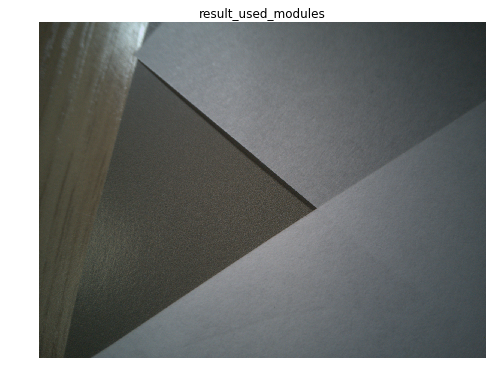

In [127]:
# 表示
plt.figure(figsize=(8, 8))
plt.imshow(gamma_img)
plt.axis('off')
plt.title(u"result_used_modules")
plt.show()